In [1]:

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


# Initialize the Qiskit IBM Runtime service
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='research-credits/200138/main',
    token= '16ecfa80cf44eae8b26ed0a1d2e00247a91f4189e46535632987c91067f2371ecfd79a9b990c4f979bea997f35ff5027540699fba74186562866a6f271b58e17'
)

/var/folders/jz/lz9dzk8n5x79flb8b8qcqymm0000gn/T/ipykernel_95893/2194644817.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


In [6]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.framework import BackendTiming
import numpy as np

# Assuming 'service' is defined elsewhere, e.g., from qiskit_ibm_runtime import QiskitRuntimeService
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
backend = service.backend("ibm_sherbrooke")
timing = BackendTiming(backend)

# twirling

delays = list(np.arange(0, 90e-6, 1e-6))
circuits = []
layout = [0]
observables = ["X", "Y"]
# delays = [0,2e-6]
# Create circuits
detuning_signs = [1, -1]  # +delta and -delta
desired_detuning = 80e3

for i, delay in enumerate(delays):
    for o in observables:
        for sign in detuning_signs:
            circ = QuantumCircuit(len(layout), len(layout))
            # Initial state preparation (for even qubits)
            for n in layout:
                if n % 2 == 0:
                    circ.h(n)

            circ.barrier()
            # Delay
            for n in layout:
                circ.delay(timing.round_delay(time=delay), n, timing.delay_unit)

            circ.barrier()
            # Add virtual detuning phase rotation with appropriate sign
            virtual_detuning = 2 * np.pi * desired_detuning  # desired_detuning in Hz
            for n in layout:
                if n % 2 != 0:
                    continue
                circ.rz(sign * virtual_detuning * delay, n)

            # Corrected basis change gates
            for n in layout:
                if n % 2 != 0:
                    continue
                if o == "X":
                    circ.h(n)
                elif o == "Y":
                    circ.sdg(n)
                    circ.h(n)
                # For "Z", no gate is needed before measurement

            circ.barrier()
            # Measurement
            for n in layout:
                circ.measure(n, n)

            # Store metadata including the sign of the detuning
            circ.metadata = {
                "xval": timing.delay_time(time=delay),
                "observable": o,
                "detuning_sign": sign
            }
            circuits.append(circ)

# Transpile circuits
# pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=layout)
# isa_circuits = [pm.run(circ) for circ in circuits]
#
# # Run with Sampler
# sampler = Sampler(backend)
# job = sampler.run(isa_circuits, shots=int(1e4))  # 10,000 shots
# result = job.result()

# Process results


In [4]:
# job = service.job('czcqdyfqadq0008cneyg') #long
job = service.job('czz45bdnhqag008twc30') #short
result = job.result()

In [7]:
# Process results
expectation_values = []
for idx, res in enumerate(result):
    # Get observable and delay from the original circuit's metadata
    o = circuits[idx].metadata["observable"]
    delay = circuits[idx].metadata["xval"]
    detuning_sign = circuits[idx].metadata["detuning_sign"]
    # Get counts from the result
    counts = res.data.c.get_counts()  # Use 'c' instead of 'meas'
    total_shots = sum(counts.values())

    # Compute P(0) and P(1) for each qubit
    num_qubits = circuits[idx].num_qubits
    p0 = [0] * num_qubits
    p1 = [0] * num_qubits
    for bitstring, count in counts.items():
        # Bitstring is a string, e.g., '000001', reversed in Qiskit (qubit 0 is rightmost)
        for q in range(num_qubits):
            if bitstring[num_qubits - 1 - q] == '0':  # Adjust for bitstring order
                p0[q] += count
            else:
                p1[q] += count
    p0 = [p / total_shots for p in p0]
    p1 = [p / total_shots for p in p1]

    # Compute expectation values: <o_n> = P(0) - P(1)
    exp_vals = [p0[n] - p1[n] for n in range(num_qubits)]

    # Store results
    expectation_values.append({
        'observable': o,
        'delay': delay,
        'exp_vals': exp_vals,  # List of <X_n>, <Y_n>, or <Z_n> for each qubit
        'detuning_sign': detuning_sign
    })

In [8]:
# Assuming expectation_values is already computed
results = [{"Xp": [], "Yp": [], "Xm":[], "Ym": []} for _ in range(len(layout))]

# Populate results with expectation values
for res_dict in expectation_values:
    observable = res_dict['observable']  # "X", "Y", or "Z"
    exp_vals = res_dict['exp_vals']      # List of expectation values for all qubits
    sign = res_dict['detuning_sign']     # +1 or -1
    for qubit_idx in range(len(layout)):
        if sign == 1:
            results[qubit_idx][observable + "p"].append(exp_vals[qubit_idx])
        else:
            results[qubit_idx][observable + "m"].append(exp_vals[qubit_idx])

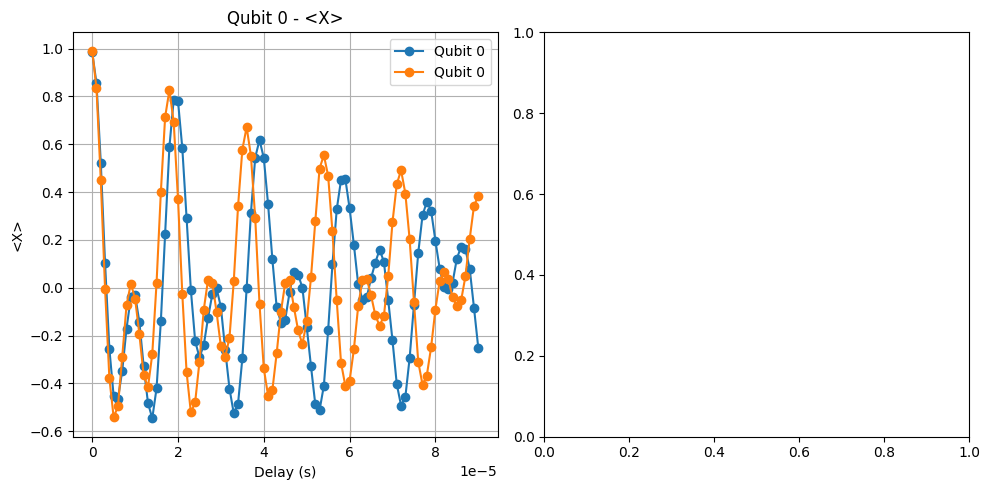

In [24]:
import matplotlib.pyplot as plt

# Assuming delays and results are already defined
# delays = list(np.arange(0, 45e-6, 2e-6))
# results = [{"X": [], "Y": [], "Z": []} for _ in range(len(layout))] populated with data

# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Flatten the axes array for easier iteration (axes is 2D: 2 rows, 3 cols)
axes_flat = axes.flatten()

# Plot "X" expectation values for each qubit
for i, x in enumerate(["Xp", "Xm"]):
    qubit = layout[0]
    ax = axes_flat[0]
    ax.plot(delays, results[0][x], marker='o', linestyle='-', label=f'Qubit {qubit}')
    ax.set_title(f'Qubit {qubit} - <X>')
    ax.set_xlabel('Delay (s)')
    ax.set_ylabel('<X>')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

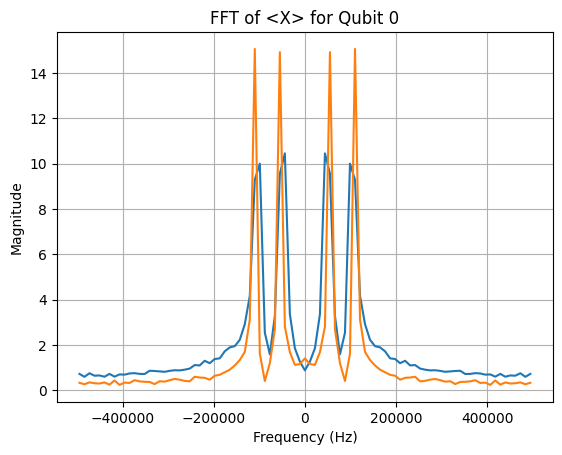

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT
fft_p = np.fft.fftshift(np.fft.fft(results[0]["Xp"]))
fft_m = np.fft.fftshift(np.fft.fft(results[0]["Xm"]))

N = len(results[0]["Xp"])  # 23
delta_t = delays[1] - delays[0]  # 2e-6 seconds
fs = 1 / delta_t  # 500 kHz
freqs = np.fft.fftshift(np.fft.fftfreq(N, d=delta_t))  # Frequencies in Hz

# Plot
plt.plot(freqs, np.abs(fft_p))
plt.plot(freqs, np.abs(fft_m))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of <X> for Qubit 0')
plt.grid(True)
plt.show()

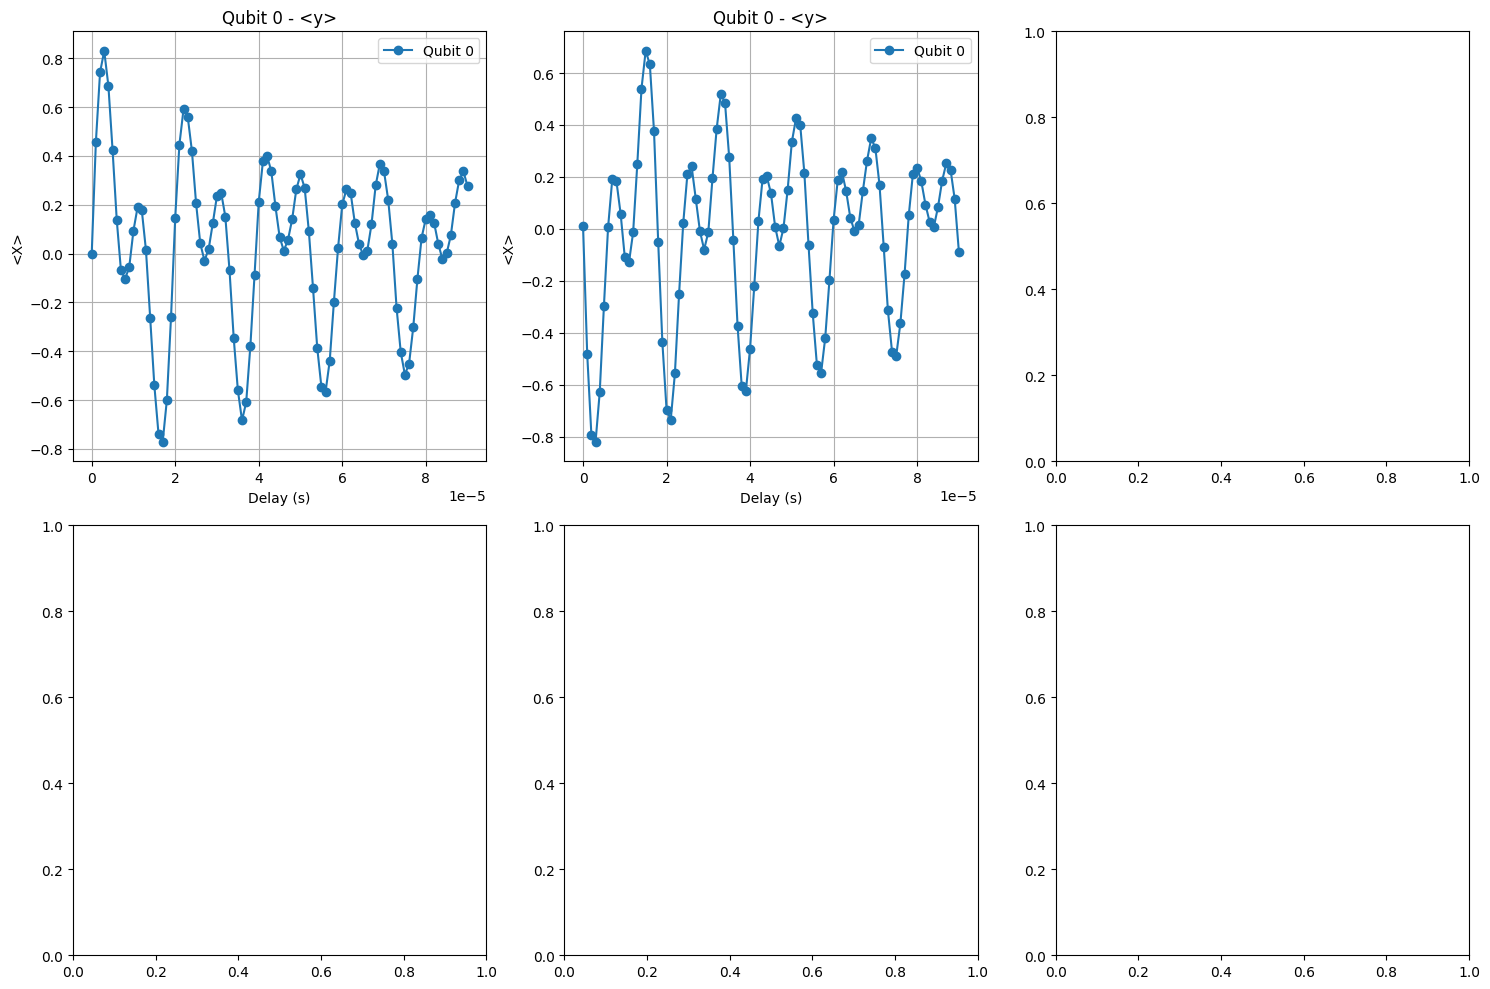

In [27]:
import matplotlib.pyplot as plt

# Assuming delays and results are already defined
# delays = list(np.arange(0, 45e-6, 2e-6))
# results = [{"X": [], "Y": [], "Z": []} for _ in range(len(layout))] populated with data

# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easier iteration (axes is 2D: 2 rows, 3 cols)
axes_flat = axes.flatten()

# Plot "X" expectation values for each qubit
for i, y in enumerate(["Yp", "Ym"]):
    qubit = layout[0]
    ax = axes_flat[i]
    ax.plot(delays, results[0][y], marker='o', linestyle='-', label=f'Qubit {qubit}')
    ax.set_title(f'Qubit {qubit} - <y>')
    ax.set_xlabel('Delay (s)')
    ax.set_ylabel('<X>')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

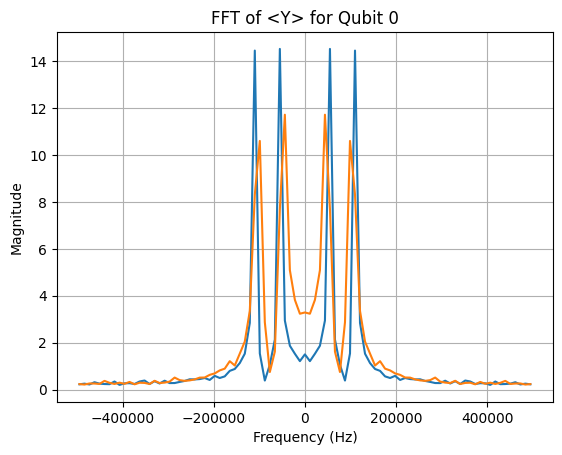

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT
fft_m = np.fft.fftshift(np.fft.fft(results[0]["Ym"]))
fft_p = np.fft.fftshift(np.fft.fft(results[0]["Yp"]))

N = len(results[0]["Ym"])  # 23
delta_t = delays[1] - delays[0]  # 2e-6 seconds
fs = 1 / delta_t  # 500 kHz
freqs = np.fft.fftshift(np.fft.fftfreq(N, d=delta_t))  # Frequencies in Hz

# Plot
plt.plot(freqs, np.abs(fft_m))
plt.plot(freqs, np.abs(fft_p))



plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of <Y> for Qubit 0')
plt.grid(True)
plt.show()



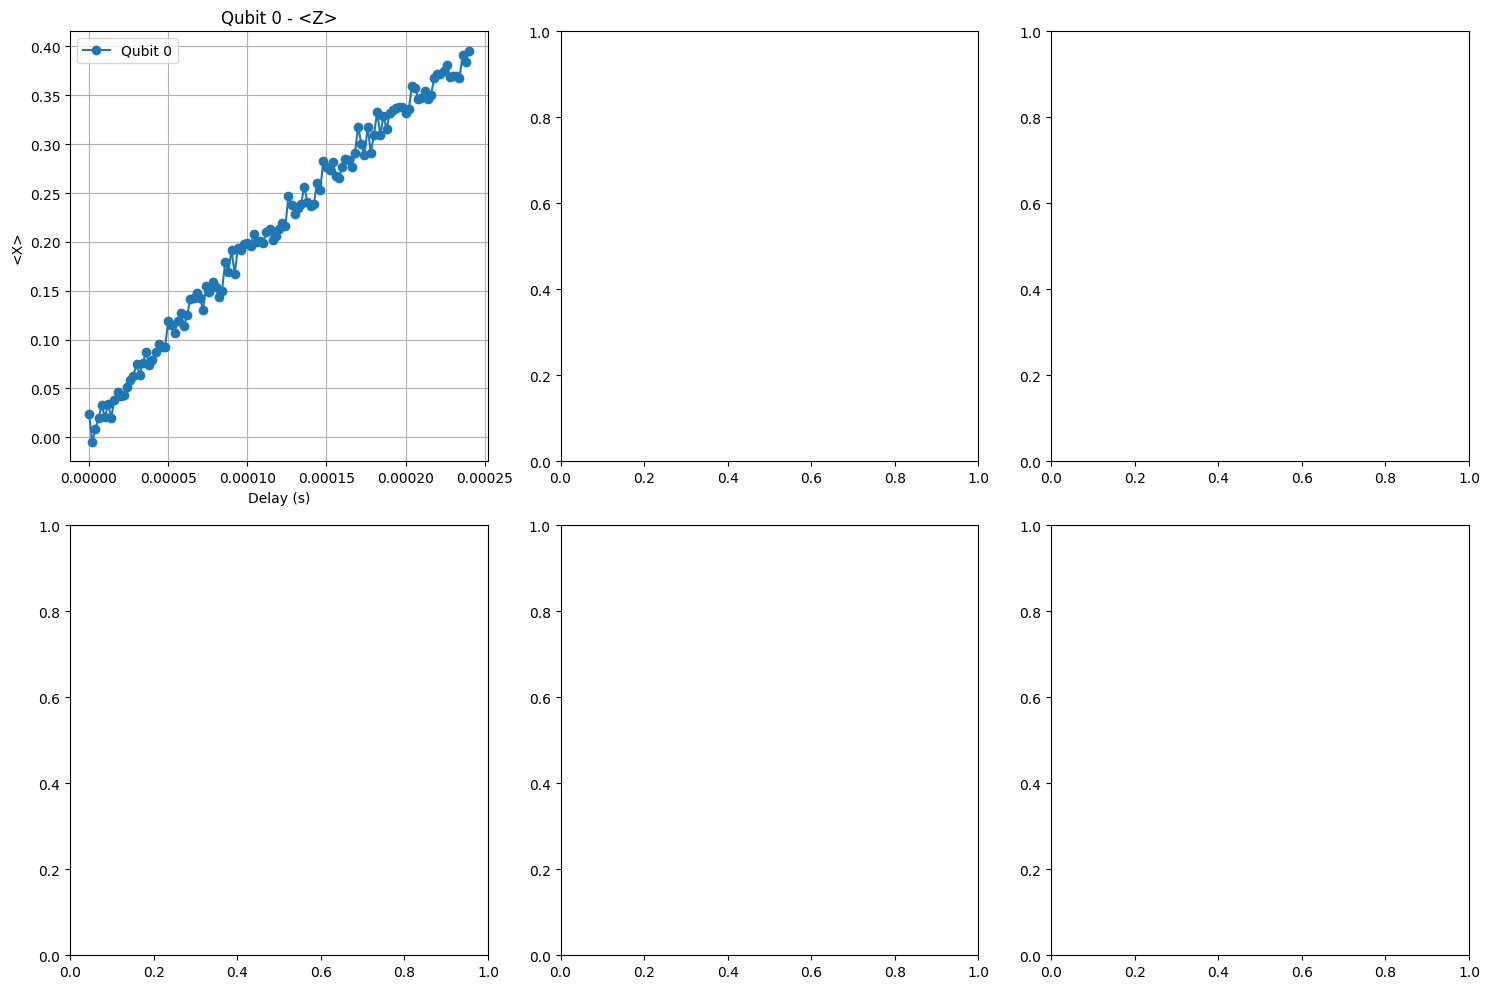

In [332]:
import matplotlib.pyplot as plt

# Assuming delays and results are already defined
# delays = list(np.arange(0, 45e-6, 2e-6))
# results = [{"X": [], "Y": [], "Z": []} for _ in range(len(layout))] populated with data

# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easier iteration (axes is 2D: 2 rows, 3 cols)
axes_flat = axes.flatten()

# Plot "X" expectation values for each qubit
for i in range(len(layout)):
    qubit = layout[i]
    ax = axes_flat[i]
    ax.plot(delays, results[i]["Z"], marker='o', linestyle='-', label=f'Qubit {qubit}')
    ax.set_title(f'Qubit {qubit} - <Z>')
    ax.set_xlabel('Delay (s)')
    ax.set_ylabel('<X>')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [10]:
import estimator
import Ramsey_ExperimentV3
q = 0
scaled_delay = (delays - np.min(delays)) / (np.max(delays) - np.min(delays)) * 10*np.pi
reverse_scaling = (1 / (1.5 * np.pi)) * (np.max(delays) - np.min(delays))
expt_nocross_modif = [[results[q]["Xp"][i]] for i in range(len(results[q]["Xp"]))]

batch_nocross = Ramsey_ExperimentV3.package_data([expt_nocross_modif], 1, 10000*8, scaled_delay, [], {}, [], [],[],[])[0]
D,W,J = estimator.one_by_one_X(batch_nocross, batch_nocross)
print(D,W,J)
t2 = 1/(2*D)
t2 = t2 * reverse_scaling
print(t2)
original_params = [x / reverse_scaling for x in [2*D[0],W[0]]]

print(original_params)

[0.08627262] [0.88919306] []
[0.00011069]
[9034.44774453394, 46558.03964216196]


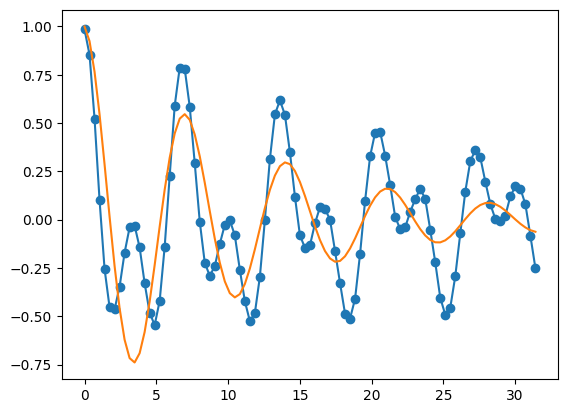

In [11]:
plt.plot(scaled_delay, results[0]["Xp"], marker='o', linestyle='-', label=f'Qubit {1}')
plt.plot(scaled_delay, [np.cos(W[0] * t)*np.exp(-D[0]*t) for t in scaled_delay], label='Fit')

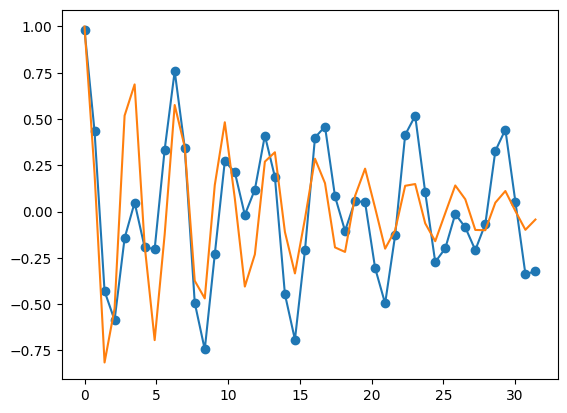

In [30]:
plt.plot(scaled_delay, results[q]["Xp"], marker='o', linestyle='-', label=f'Qubit {q}')
plt.plot(scaled_delay, [np.cos(W[0] * t)*np.exp(-D[0]*t) for t in scaled_delay], label='Fit')

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the two functions
def func_x(x, a1, b,c, w1, w2,const1):
    return (const1 + b * np.cos(w1 * x) + c * np.cos(w2 * x)) * np.exp(-a1 * x)

def func_y(x, a2, d,e, w3, w4, const2):
    return (const2 + d * np.sin(w3 * x) + e * np.sin(w4 * x)) * np.exp(-a2 * x)

# Combined function for simultaneous fitting
def combined_func(x, a1,a2, b,c,d,e, w1, w2, w3, w4, const1, const2):
    x_x = x[:len(x)//2]  # First half for X data
    x_y = x[len(x)//2:]  # Second half for Y data
    return np.concatenate([func_x(x_x, a1, b,c, w1, w2, const1),
                          func_y(x_y, a2, d,e, w3, w4, const2)])

# Assuming 'results' and 'q' are defined elsewhere in your code
# Generate sample time points based on X data length
X = results[q]["Xp"]
Y = results[q]["Yp"]
t = np.linspace(0, 1.5 * np.pi, len(X))  # Changed from len(delays) to len(X)

# Combine the data
x_data = np.concatenate([t, t])  # x-values for both functions
y_data = np.concatenate([X, Y])  # corresponding y-values

# Initial parameter guesses
initial_guess = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,0.0,0.0]  # 6 parameters: a, b, w1, w2, w3, w4

# Perform the curve fitting
try:
    popt, pcov = curve_fit(combined_func, x_data, y_data, p0=initial_guess)

    # Extract fitted parameters
    a1_fit,a2_fit, b_fit,c_fit,d_fit,e_fit, w1_fit, w2_fit, w3_fit, w4_fit, const1_fit, const2_fit = popt

    # Calculate fitted curves with correct parameters
    X_fit = func_x(t, a1_fit, b_fit,c_fit, w1_fit, w2_fit, const1_fit)
    Y_fit = func_y(t, a2_fit, d_fit,e_fit, w3_fit, w4_fit, const2_fit)

    # Print results with corrected labels
    print("Fitted parameters:")
    print(f"a1 = {a1_fit:.3f}")
    print(f"a2 = {a2_fit:.3f}")
    print(f"b = {b_fit:.3f}")
    print(f"w1 = {w1_fit:.3f}")
    print(f"w2 = {w2_fit:.3f}")
    print(f"w3 = {w3_fit:.3f}")
    print(f"w4 = {w4_fit:.3f}")
    print(f"const1 = {const1_fit:.3f}")
    print(f"const2 = {const2_fit:.3f}")


    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot X data and fit
    plt.subplot(2, 1, 1)
    plt.scatter(t, X, label='X Data', alpha=0.5)
    plt.plot(t, X_fit, 'r-', label='X Fit')
    plt.xlabel('t')
    plt.ylabel('X')
    plt.legend()

    # Plot Y data and fit
    plt.subplot(2, 1, 2)
    plt.scatter(t, Y, label='Y Data', alpha=0.5)
    plt.plot(t, Y_fit, 'r-', label='Y Fit')
    plt.xlabel('t')
    plt.ylabel('Y')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
except RuntimeError as e:
    print(f"Fitting failed: {e}")

NameError: name 'results' is not defined

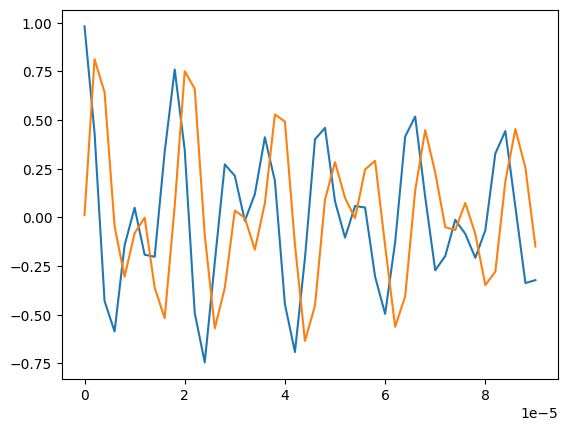

In [34]:
plt.plot(delays,X)
plt.plot(delays,Y)

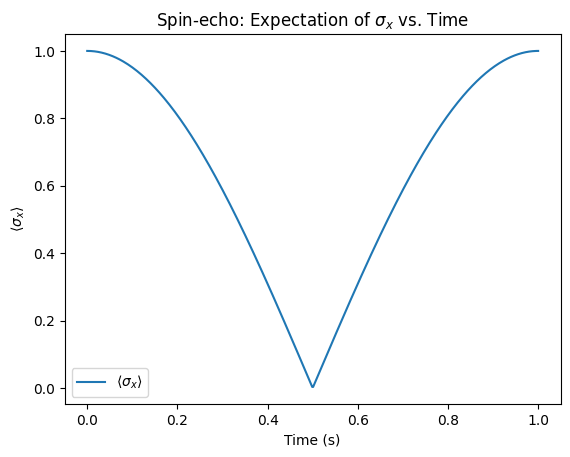

In [321]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Delta = 2.0 * np.pi  # detuning in rad/s (example)
T = 1.0             # total time in seconds (example)
N = 500             # number of points to sample

t_vals = np.linspace(0, T, N)
sx_vals = np.zeros_like(t_vals)

for i, t in enumerate(t_vals):
    if t <= T/2:
        # 0 <= t <= T/2
        sx_vals[i] = np.cos(0.5 * Delta * t)
    else:
        # T/2 < t <= T
        sx_vals[i] = np.cos(0.5 * Delta * (t - T))

plt.plot(t_vals, sx_vals, label=r'$\langle \sigma_x \rangle$')
plt.xlabel('Time (s)')
plt.ylabel(r'$\langle \sigma_x \rangle$')
plt.title('Spin-echo: Expectation of $\\sigma_x$ vs. Time')
plt.legend()
plt.show()
